In [116]:
# Read In Dependencies
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy
from matplotlib import pyplot as plt
from scipy.stats import boxcox

#Read In Data
df_train = pd.read_csv('/Users/jonathanbugg/Desktop/lin_reg_proj/data/2016_cleaned.csv')

# Set Randomization Defaults
np.random.seed(21)

target = 'logerror'
pid = 'parcelid'

# Set Aesthetic Defaults
plt.style.use('seaborn-darkgrid')
%matplotlib inline

In [120]:
#Helper Functions
def run_multiple_regression_ols(df, X_list, print_output = False):
    X = sm.add_constant(df.loc[:, X_list]) # Predictor Matrix: IV + Constant
    y = df.Y # Prediction Targets
    # Fit, summarize OLS regression
    model = sm.OLS(y, X)
    result = model.fit()
    
    if print_output == True:
        print(result.summary())
        
    resids = result.resid
    preds = result.predict(X)
    
    return result, resids, preds


def backward_regression(X, y,initial_list=[], threshold_in=0.01, threshold_out = 0.05, verbose=True):
    included=list(X.columns)
        
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Feature Dropped: {worst_feature} (p = {worst_pval:.3f})')
        if not changed:
            break
    return included

def normal_probability_plot(result, resids):
    
    resid_df = pd.DataFrame(resids, columns = ['resid'])
    resid_df = resid_df.sort_values(by = 'resid').reset_index(drop = True).reset_index().rename({'index':'k'}, axis = 1)
    resid_df.k = resid_df.k + 1
    resid_df['expected_value'] = resid_df.apply(lambda x: np.sqrt(result.mse_resid) * scipy.stats.norm().ppf((x.k - .375)/(len(resid_df) + .25)), axis = 1)

    fig = plt.scatter(resid_df.expected_value, resid_df.resid)

    plt.xlabel('Expected')
    plt.ylabel('Residual')
    plt.title('Normal Probability Plot of Residuals')
    
    plt.show()
    
def plot_resid_pred(resid, pred, range_above = True):
    plt.figure(figsize=(10, 6))
    plt.scatter(pred, resid, s = 2.5)
    mean = pred.mean()
    std_dev = pred.std()
    if range_above:
        plt.xlim([0, mean + 4 * std_dev])
    plt.xlabel(pred.name)
    plt.ylabel('Residual Value')
    plt.title('Residual Values v. ' + pred.name)
    plt.axhline(color = 'black', linestyle = 'dashed')
    plt.show()
    


# First Full Model

## Training First Full Model

In [118]:
drop_cols = [
    'fips_6111.0','heatingorsystemtypeid_24.0','regionidcity_9840.0','propertylandusetypeid_275.0','propertycountylandusecode_96', # Arbitrary Category Labels dropped for intercept hardening
    'assessmentyear', # No Cardinality (singular valued feature)
    'yearbuilt'
]
df_train['Y'] = df_train.logerror
training_cols = [i for i in df_train.columns if i not in [pid, target,'transactiondate','Y','census_tract','censustractandblock']]
training_cols = [i for i in training_cols if i not in drop_cols]
print(len(training_cols))
result_full, resids_full, preds_full = run_multiple_regression_ols(df_train, training_cols, True)

270
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     5.433
Date:                Wed, 13 Apr 2022   Prob (F-statistic):          4.79e-160
Time:                        20:40:20   Log-Likelihood:                 37569.
No. Observations:               89670   AIC:                        -7.460e+04
Df Residuals:                   89402   BIC:                        -7.208e+04
Df Model:                         267                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const   

## Diagnostics of First Full Model

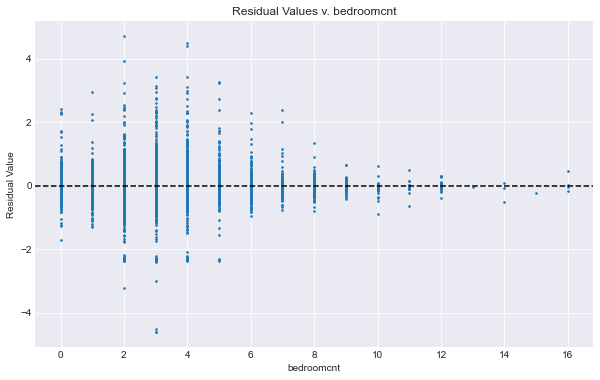

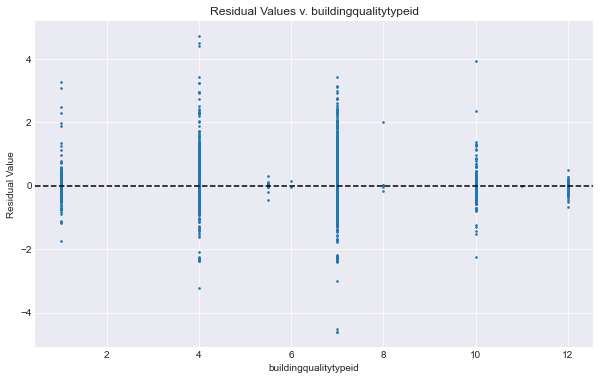

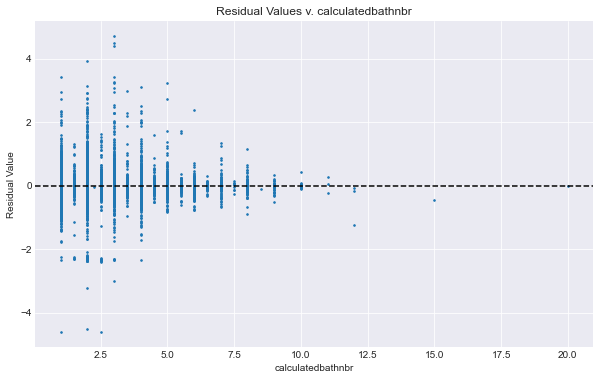

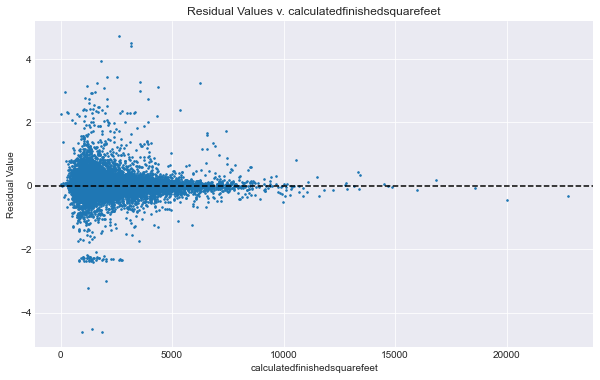

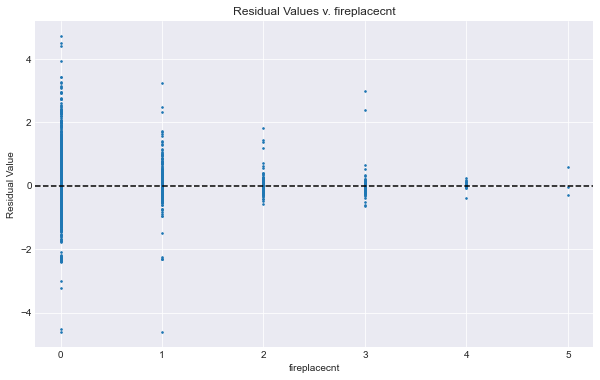

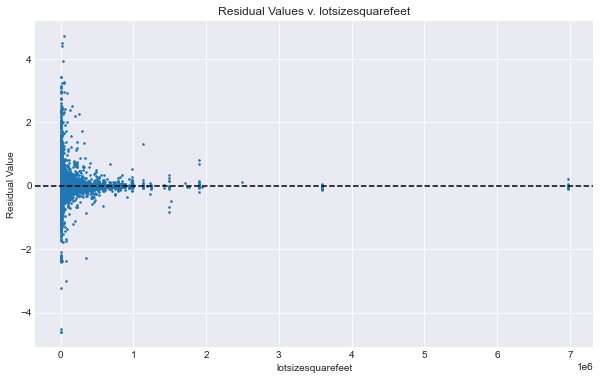

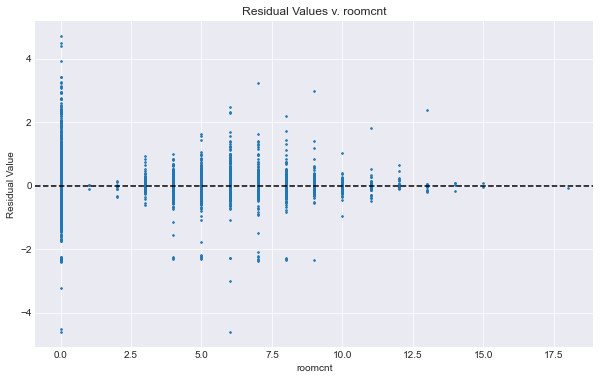

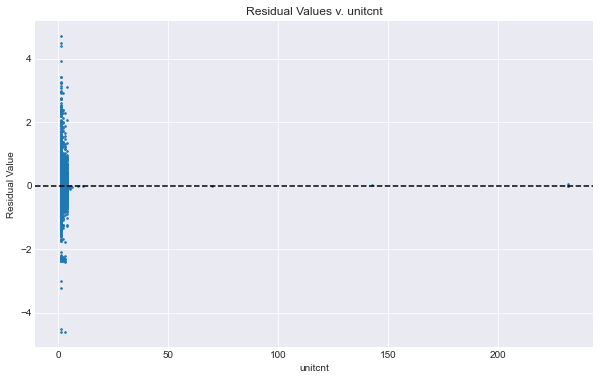

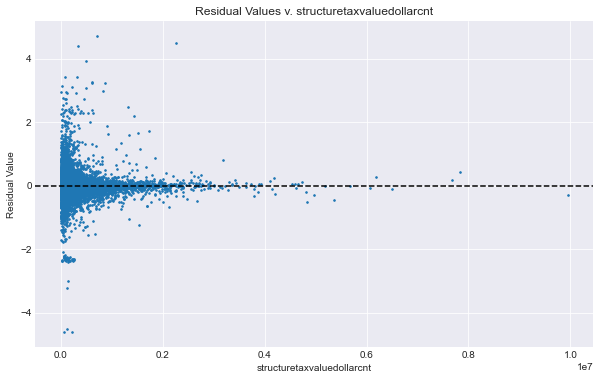

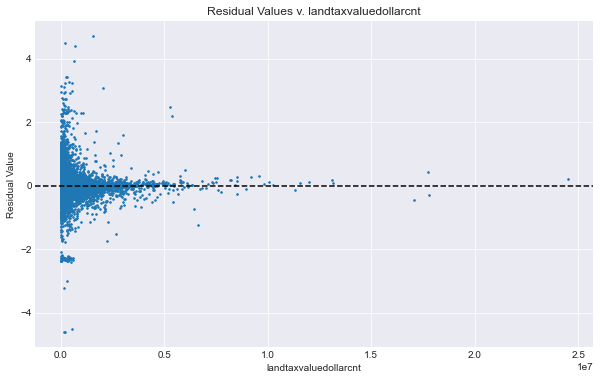

In [119]:
for column in [i for i in training_cols if i in continuous_cols]:
    plot_resid_pred(resids_full, df_train[column], range_above = False)

# Second Model: Box Cox Transformations

In [81]:
_, l = boxcox(df_train.logerror + np.abs(df_train.logerror.min()) + .000001) 
print(f'Y Box-Cox lambda: {l:.3f}')

Y Box-Cox lambda: 0.970


## Transformations on Predictors


In [98]:
continuous_cols = ['bedroomcnt','buildingqualitytypeid','calculatedbathnbr','calculatedfinishedsquarefeet','fireplacecnt','lotsizesquarefeet','roomcnt','unitcnt','yearbuilt','structuretaxvaluedollarcnt','landtaxvaluedollarcnt']
    
for i in continuous_cols:
    print(i)
    var = df_train.loc[:, i]
    
    if var.min() <= 0:
        var = var + np.abs(var.min()) + .000001
        df_train.loc[:, i] = df_train.loc[:, i] + np.abs(df_train.loc[:, i].min()) + .000001
        
    _, l = boxcox(var) 
    print(f' Box-Cox Transformed lambda: {l:.3f}')

    df_train.loc[:, i] = np.power(df_train.loc[:, i], l)
    

print('')
print('QC: post-transformation Lambda Values')

for i in continuous_cols:
    print(i)
    var = df_train.loc[:, i]
    
    _, l = boxcox(var) 
    
    print(f' Box-Cox Transformed lambda: {l:.3f}')
    
# Censor Extreme values
for i in continuous_cols:
    var_mean = df_train.loc[:, i].mean()
    var_std = df_train.loc[:, i].std()
    
    df_train.loc[df_train.loc[:, i] < var_mean - 3 * var_std, i] = var_mean - 3 * var_std
    df_train.loc[df_train.loc[:, i] > var_mean + 3 * var_std, i] = var_mean + 3 * var_std

bedroomcnt
 Box-Cox Transformed lambda: 0.680
buildingqualitytypeid
 Box-Cox Transformed lambda: 1.457
calculatedbathnbr
 Box-Cox Transformed lambda: 0.215
calculatedfinishedsquarefeet
 Box-Cox Transformed lambda: -0.149
fireplacecnt
 Box-Cox Transformed lambda: -0.670
lotsizesquarefeet
 Box-Cox Transformed lambda: -0.395
roomcnt
 Box-Cox Transformed lambda: -0.258
unitcnt
 Box-Cox Transformed lambda: -6.172
yearbuilt
 Box-Cox Transformed lambda: 11.583
structuretaxvaluedollarcnt
 Box-Cox Transformed lambda: 0.057
landtaxvaluedollarcnt
 Box-Cox Transformed lambda: 0.118

QC: post-transformation Lambda Values
bedroomcnt
 Box-Cox Transformed lambda: 1.000
buildingqualitytypeid
 Box-Cox Transformed lambda: 1.000
calculatedbathnbr
 Box-Cox Transformed lambda: 1.000
calculatedfinishedsquarefeet
 Box-Cox Transformed lambda: 1.000
fireplacecnt
 Box-Cox Transformed lambda: 1.000
lotsizesquarefeet
 Box-Cox Transformed lambda: 1.000
roomcnt
 Box-Cox Transformed lambda: 1.000
unitcnt
 Box-Cox Tra

/Users/jonathanbugg/Desktop/crypto_portfolio_opt/venv/lib/python3.8/site-packages/scipy/stats/morestats.py:912: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/Users/jonathanbugg/Desktop/crypto_portfolio_opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/jonathanbugg/Desktop/crypto_portfolio_opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/jonathanbugg/Desktop/crypto_portfolio_opt/venv/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


## Training Box Cox Model

In [99]:
df_train['Y'] = df_train.logerror
training_cols = [i for i in df_train.columns if i not in [pid, target,'transactiondate','Y','census_tract','censustractandblock']]
training_cols = [i for i in training_cols if i not in drop_cols]

In [105]:
result_box_cox, resids_box_cox, preds_box_cox = run_multiple_regression_ols(df_train, training_cols, True)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     5.160
Date:                Wed, 13 Apr 2022   Prob (F-statistic):          2.29e-147
Time:                        20:22:16   Log-Likelihood:                 37533.
No. Observations:               89670   AIC:                        -7.453e+04
Df Residuals:                   89402   BIC:                        -7.201e+04
Df Model:                         267                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

## Box Cox Model Diagnostics

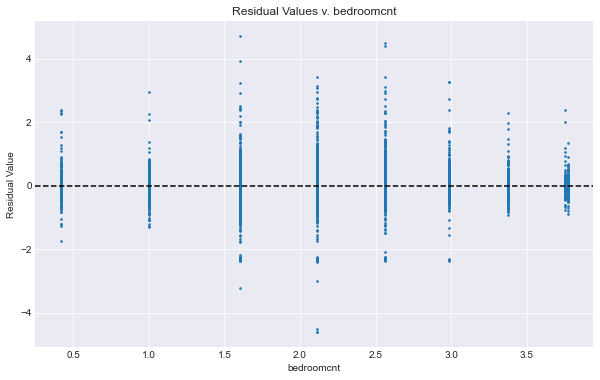

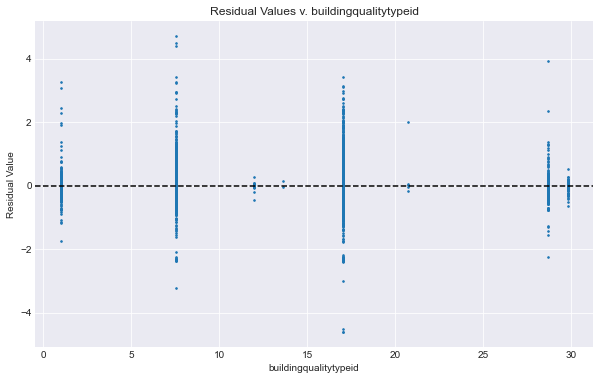

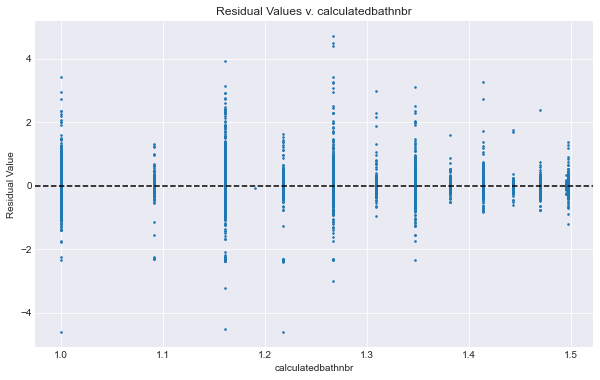

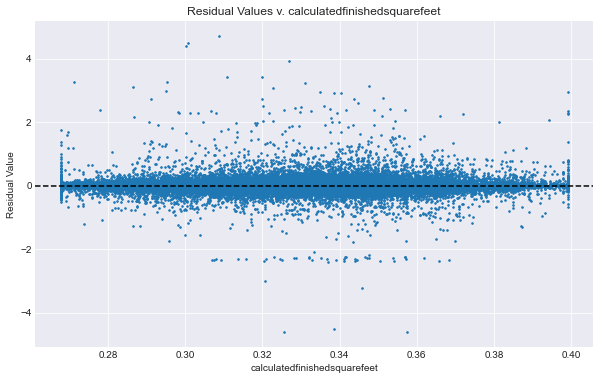

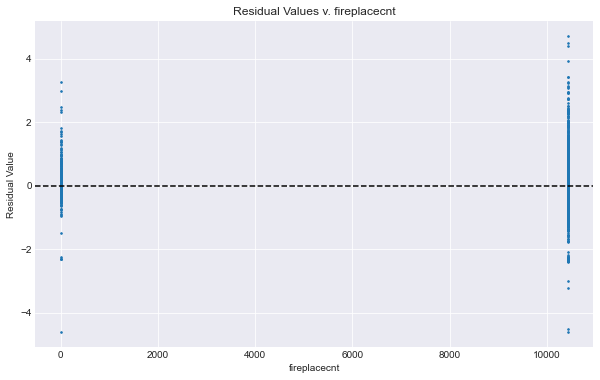

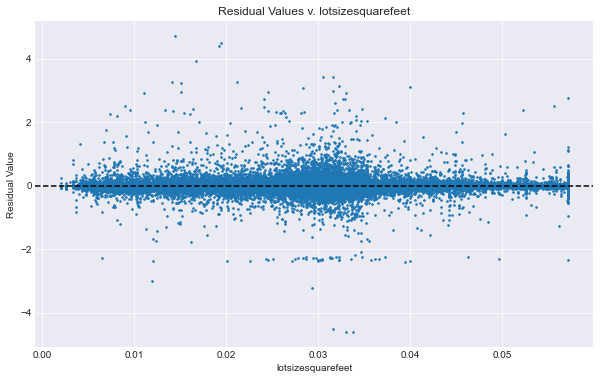

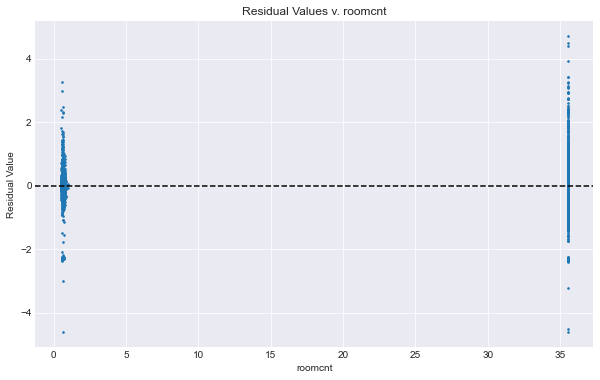

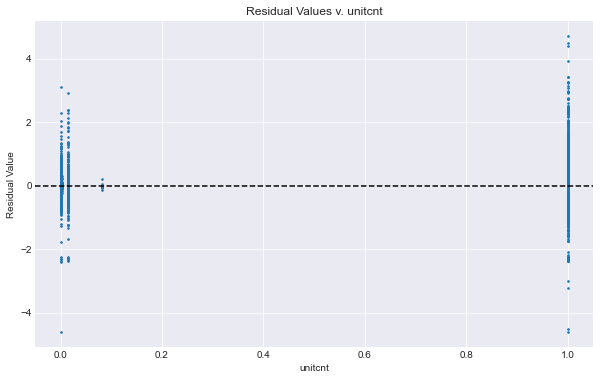

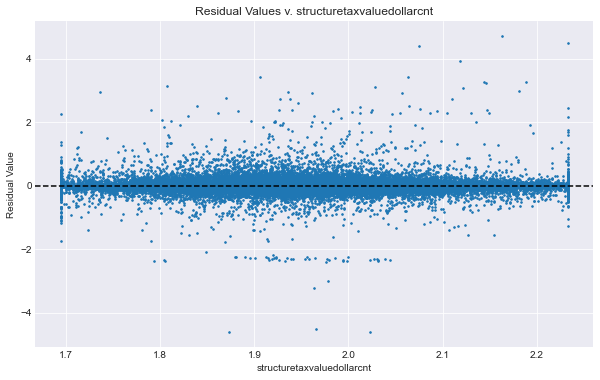

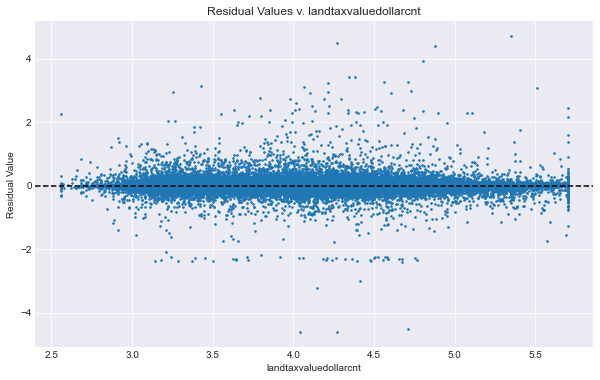

In [106]:
for column in [i for i in training_cols if i in continuous_cols]:
    plot_resid_pred(resids_box_cox, df_train[column], range_above = False)

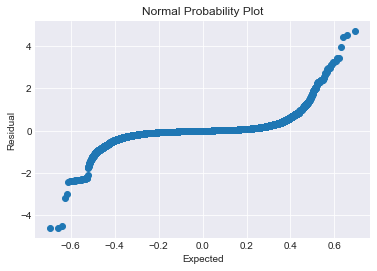

In [108]:
normal_probability_plot(result_box_cox, resids_box_cox)

# Third Model: Reduced Model with Backward Stepwise Regression

## Determing Features to include in Reduced Model

In [112]:
backward_X = df_train[training_cols]
backward_x_cols = list(backward_X.columns)
backward_y = df_train['logerror']
backwards_test = backward_regression(backward_X, backward_y, verbose = True)

Feature Dropped: regionidcity_113576.0 (p = 0.969)
Feature Dropped: regionidcity_45457.0 (p = 0.959)
Feature Dropped: regionidcity_46178.0 (p = 0.964)
Feature Dropped: regionidcity_40110.0 (p = 0.960)
Feature Dropped: regionidcity_25459.0 (p = 0.955)
Feature Dropped: regionidcity_15554.0 (p = 0.971)
Feature Dropped: regionidcity_33727.0 (p = 0.946)
Feature Dropped: heatingorsystemtypeid_13.0 (p = 0.944)
Feature Dropped: propertycountylandusecode_1310 (p = 0.942)
Feature Dropped: regionidcity_53571.0 (p = 0.940)
Feature Dropped: regionidcity_11626.0 (p = 0.937)
Feature Dropped: regionidcity_34780.0 (p = 0.929)
Feature Dropped: regionidcity_21412.0 (p = 0.925)
Feature Dropped: regionidcity_10815.0 (p = 0.919)
Feature Dropped: regionidcity_25458.0 (p = 0.912)
Feature Dropped: regionidcity_33612.0 (p = 0.907)
Feature Dropped: regionidcity_396556.0 (p = 0.893)
Feature Dropped: regionidcity_33252.0 (p = 0.890)
Feature Dropped: regionidcity_24435.0 (p = 0.888)
Feature Dropped: heatingorsystem

## Train Reduced Model

In [113]:
print(len(backwards_test))
result_red, resids_red, preds_red = run_multiple_regression_ols(df_train, backwards_test, True)

83
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     15.09
Date:                Wed, 13 Apr 2022   Prob (F-statistic):          3.65e-199
Time:                        20:36:21   Log-Likelihood:                 37447.
No. Observations:               89670   AIC:                        -7.473e+04
Df Residuals:                   89589   BIC:                        -7.397e+04
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const    

## Diagnostics

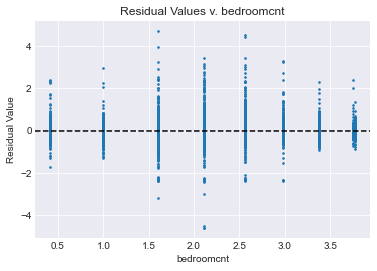

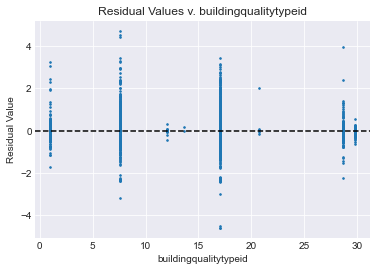

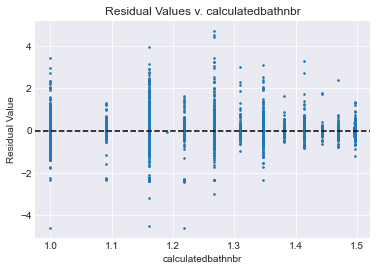

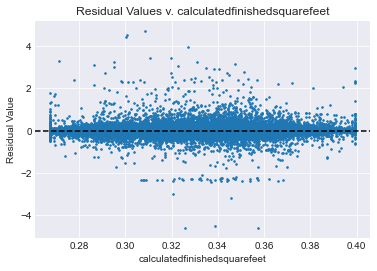

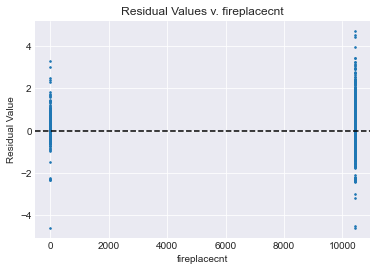

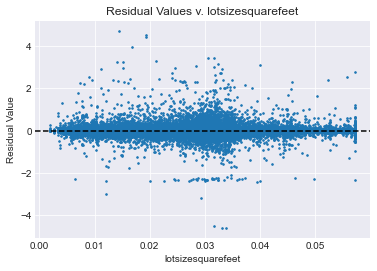

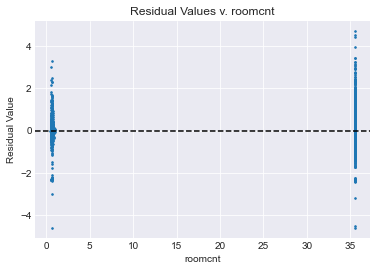

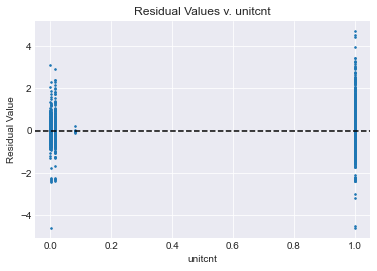

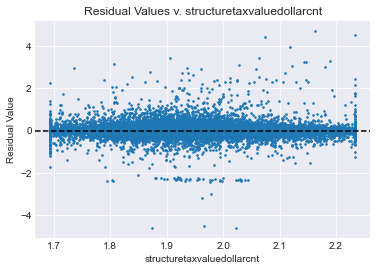

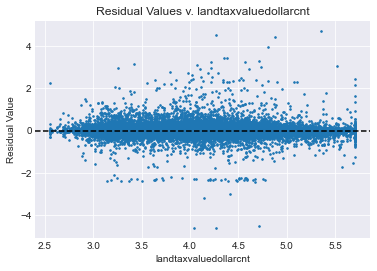

In [12]:
for column in [i for i in training_cols if i in continuous_cols]:
    plot_resid_pred(resids_red, df_train[column])

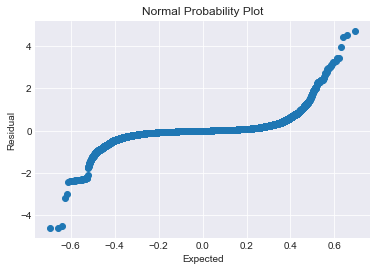

In [13]:
normal_probability_plot(result_red, resids_red)

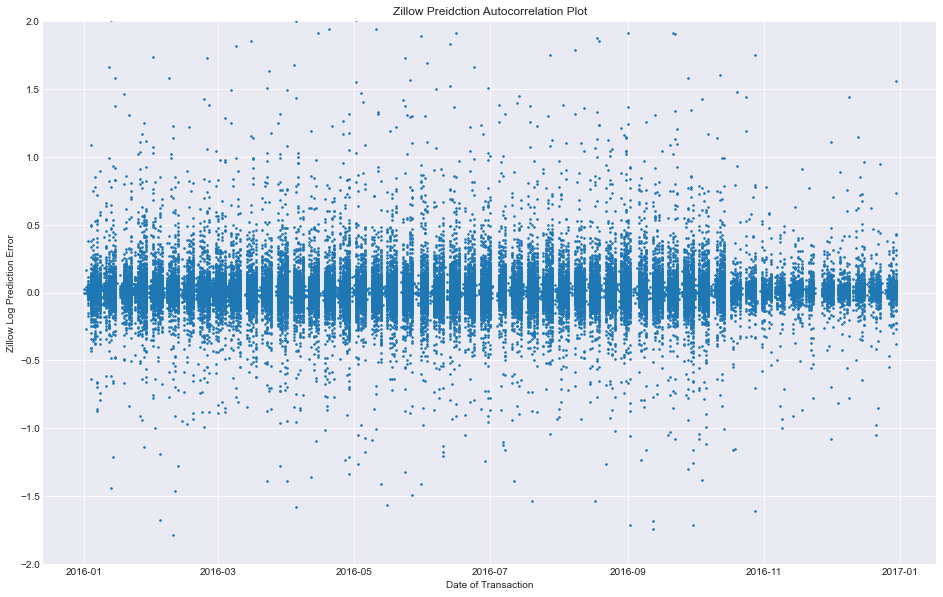

In [123]:
df = df_train.loc[:, ['transactiondate','logerror']]
df.transactiondate = pd.to_datetime(df.transactiondate)
plt.figure(figsize=(16, 10))
plt.scatter(df.transactiondate, df.logerror, s = 2.5)
plt.ylabel('Zillow Log Prediction Error')
plt.xlabel('Date of Transaction')

plt.title('Zillow Preidction Autocorrelation Plot')

plt.ylim([-2,2])

plt.show()

## Hypothesis Testing

In [114]:
sse_full = result_full.ssr
dof_full = result_full.df_resid
sse_reduced = result_red.ssr
dof_reduced = result_red.df_resid
F = scipy.stats.f.ppf(.99, dof_reduced - dof_full, dof_full)

F_star = (sse_reduced - sse_full)/(dof_reduced - dof_full)/(sse_full/dof_full)
print(f'F-statistic Reference Value: {F:.3f}')
print(f'F-star:                      {F_star:.3f}')

F-statistic Reference Value: 1.257
F-star:                      0.913
